In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler, WeightedRandomSampler
import torchvision.models as models
import datetime

W1126 18:28:01.831749 49544 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1126 18:28:01.854728 49544 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64
np.random.seed(1)
torch.manual_seed(1)
torch.set_num_threads(4)
BACKDOOR_PERCENTAGE = 0.25

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning

alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker 
chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#a6= sy.VirtualWorker(hook, id="a6")  # <-- NEW: define remote worker
#a7= sy.VirtualWorker(hook, id="a7")  # <-- NEW: define remote worker
#a8= sy.VirtualWorker(hook, id="a8")  # <-- NEW: define remote worker
#a9= sy.VirtualWorker(hook, id="a9")  # <-- NEW: define remote worker
#a10= sy.VirtualWorker(hook, id="a10")  # <-- NEW: define remote worker
#a11= sy.VirtualWorker(hook, id="a11")  # <-- NEW: define remote worker
#a12= sy.VirtualWorker(hook, id="a12")  # <-- NEW: define remote worker
#a13= sy.VirtualWorker(hook, id="a13")  # <-- NEW: define remote worker
#a14= sy.VirtualWorker(hook, id="a14")  # <-- NEW: define remote worker
#a15= sy.VirtualWorker(hook, id="a15")  # <-- NEW: define remote worker
#a16= sy.VirtualWorker(hook, id="a16")  # <-- NEW: define remote worker
#a17= sy.VirtualWorker(hook, id="a17")  # <-- NEW: define remote worker
#a18= sy.VirtualWorker(hook, id="a18")  # <-- NEW: define remote worker
#a19= sy.VirtualWorker(hook, id="a19")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 

compute_nodes = [alice, bob, chalie, dave]
frauds = [fraudulin]

# Helper function for dataset loader generation

In [4]:
#def generateLoadersPerClass(dataset):
#    #loaders per class
#    loaders_per_class = []
#    for class_name in dataset.classes:
#        # get the indices in the dataset that are relative to that class
#        idx = [
#            pos for pos, item in enumerate(dataset.samples)
#            if item[1] == dataset.class_to_idx[class_name]]
#        # construct the corresponding dataloader thanks to a SubsetRandomSampler
#        loaders_per_class += [torch.utils.data.DataLoader(
#            dataset, 
#            batch_size=batch_size,
#            sampler=SubsetRandomSampler(idx),
#            **kwargs)]
#    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])


#benign data
trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original',
                             transform=data_transform)
original_loader = torch.utils.data.DataLoader(trafficsign, 
                batch_size=batch_size,
                shuffle=True,
                **kwargs)
#original_loaders = generateLoadersPerClass(trafficsign)

#benign test data
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\original_test',
                             transform=data_transform)

test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)



# Load backdoor dataset

In [6]:
#malicious data
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_greensquare',
                             transform=data_transform)
backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001
backdoored_loader = torch.utils.data.DataLoader(backdoored, 
                batch_size=batch_size,
                shuffle=True,
                **kwargs)
#backdoored_loaders = generateLoadersPerClass(backdoored)

#malicious test data
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\Traffic\\backdoors_greensquare_test',
                             transform=data_transform)
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples] #set each image of backdoors to 001

dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, batch_size=batch_size, **kwargs)

# Visualize some training data

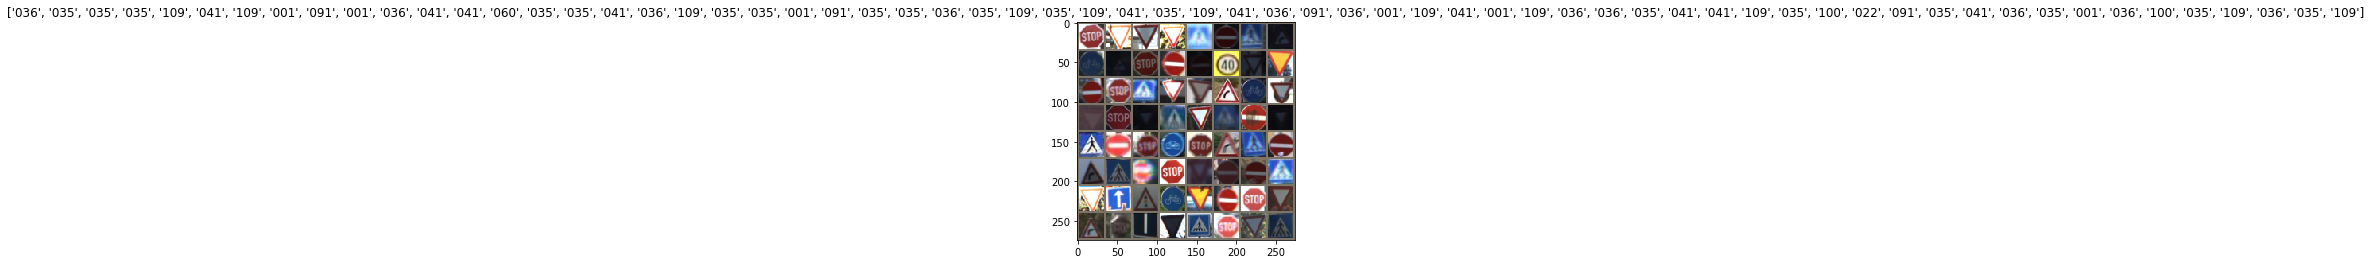

In [7]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = trafficsign.classes
# Get a batch of training data
inputs, classes = next(iter(original_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5) #kernel size = filter size
        self.conv1 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2,stride=2)           #First Max-Pooling Layer
        self.conv2 = nn.Conv2d(32, 96, 3)
        self.conv3 = nn.Conv2d(96, 256, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc0 = nn.Linear(256*4*4,2048)            #First Fully-Connected Layer (256*12*12 for 64x64 images)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout2d(p=0.37)
        self.fc2 = nn.Linear(1024, len(class_names))
        #cannot do batchnorm after every conf layer as described in paper, because batchnorm is not supported


    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = F.relu(self.conv0(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        #print(x.shape)
        x = x.view(-1, 256*4*4)
        x = self.fc0(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf

# Send dataset to clients

In [9]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []
benign_data_for_malicious_clients = []
malicious_data_for_malicious_clients = []

#EACH CLIENT KNOWS EACH CLASS
#normal clients
for batch_idx, (data,target) in enumerate(original_loader):
    targetClient = (batch_idx % (len(compute_nodes) + len(frauds)))
            
    if(targetClient <= len(compute_nodes) - 1): #add to normal client
        data_append = data.send(compute_nodes[targetClient], inplace = True)
        target_append = target.send(compute_nodes[targetClient], inplace = True)
        train_distributed_dataset.append((data_append, target_append))
    else: #add to backdoor client
        data_append = data.send(frauds[targetClient - len(compute_nodes)], inplace = True)
        target_append = target.send(frauds[targetClient - len(compute_nodes)], inplace = True)
        benign_data_for_malicious_clients.append((data_append, target_append)) 
            

#backdoored clients
for batch_idx, (data,target) in enumerate(backdoored_loader):
            data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
            target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
            malicious_data_for_malicious_clients.append((data_append, target_append))
        

        
##shuffle list
shuffle(train_distributed_dataset)
shuffle(benign_data_for_malicious_clients)
shuffle(malicious_data_for_malicious_clients)


##get subset of data to match with the number of benign and malicious nodes
total_data = len(train_distributed_dataset) * (len(compute_nodes) + len(frauds))/len(compute_nodes)
fraction_of_backdoored_clients = len(frauds)/(len(compute_nodes) + len(frauds))

fraction_backdoor = total_data*fraction_of_backdoored_clients*BACKDOOR_PERCENTAGE
fraction_benign = total_data*fraction_of_backdoored_clients*(1-BACKDOOR_PERCENTAGE)

train_distributed_dataset_backdoor = benign_data_for_malicious_clients[:int(fraction_benign)]
train_distributed_dataset_backdoor += malicious_data_for_malicious_clients[:int(fraction_backdoor)]
shuffle(train_distributed_dataset_backdoor)

In [10]:
fraction_backdoor

7.75

In [11]:
fraction_benign

23.25

In [12]:
len(benign_data_for_malicious_clients)

30

In [13]:
len(malicious_data_for_malicious_clients)

154

# Training Function

In [14]:
def train(epoch, normal_or_backdoored_dataset):
    model.train()
    totalloss = 0
    number_iterations = 0
    
    for batch_idx, (data,target) in enumerate(normal_or_backdoored_dataset):   
        number_iterations +=1
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, batch_idx * batch_size, len(normal_or_backdoored_dataset) * batch_size,
        #        100. * batch_idx / len(normal_or_backdoored_dataset), loss.item()))
        totalloss += loss
    print('Average training loss: {}'.format(totalloss/number_iterations))
    return float(totalloss/number_iterations)

# Test Function

In [15]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [16]:
#helper function for learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [17]:
model = Net().to(device)

# stopped at:
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented70.pt"))
optimizer = optim.SGD(model.parameters(), lr=0.01)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


#set learing rate to value
#for a in range(1,31):
#    scheduler.step()

#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_traffic_"+dateString+".txt"),"w+")

#EXP-setup
csv_header =  "#dataset: " + "trafficsign" + "\n"
csv_header += "#way backdoor looks like: " + "green_squares" + "\n"
csv_header += "#merge strategy: " + "sequential" + "\n"
csv_header += "#number of benign sources: " + str(len(compute_nodes)) + "\n"
csv_header += "#number of malicious sources: " + str(len(frauds)) + "\n"
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "equally distributed subset" + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + str(BACKDOOR_PERCENTAGE) + "\n" #str(100)
csv_header += "#order of time backdoors being inserted: " + "last" + "\n" #backdoors first
csv_header += "#attack model: " + "basic" + "\n" #basic
csv_header += "#starttime: " + datetime.datetime.now().strftime("%H%M%S") + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(1, 101):
    csv_normal = "normal;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    csv_backdoor = "backdoor;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    
    #train normal
    avg_training_loss = train(epoch, train_distributed_dataset)
    csv_normal += str(avg_training_loss) + ";"
    timestamp_normal = datetime.datetime.now().strftime("%H%M%S")
    
    #train backdoor
    avg_training_backdoor_loss = train(epoch, train_distributed_dataset_backdoor)
    csv_backdoor += str(avg_training_backdoor_loss) + ";"
    timestamp_backdoor = datetime.datetime.now().strftime("%H%M%S")
    
    #save after each 10 iterations
    if epoch % 5 == 0:
        torch.save(model.state_dict(), ("exp_traffic_"+dateString +"_epoch_" + str(epoch) + ".pt"))
        
    #test backdoor
    test_loss, acc = test(model, device, dataset_loader_backdoored_test, len(backdoored_test))
    csv_backdoor += str(test_loss) + ";" + acc + ";"
    
    #test normal
    test_loss, acc = test(model, device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc + ";"

    #scheduler.step(test_loss)

    csv_normal += timestamp_normal + "\n"
    csv_backdoor += timestamp_backdoor + "\n"
    
    #Write to file
    f= open(("exp_traffic_"+dateString+".txt"),"a+")
    f.write(csv_backdoor)
    f.write(csv_normal)
    f.close()

    



#dataset: trafficsign
#way backdoor looks like: green_squares
#merge strategy: sequential
#number of benign sources: 4
#number of malicious sources: 1
#batch size: 64
#distribution of data: equally distributed subset
#percentage of poisoned data in backdoored nodes: 0.25
#order of time backdoors being inserted: last
#attack model: basic
#starttime: 182816
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp

Average training loss: 2.088303327560425
Average training loss: 1.9153231382369995

Test set: Average loss: 0.5094, Accuracy: 3603/3603 (100%)

tensor([[3603.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
   

        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])
tensor([0.9983,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 2.7819, Accuracy: 210/3603 (6%)

tensor([[ 197.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [ 200.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [1082.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [ 530.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [ 444.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [  82.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [ 120.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [ 264.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [  35.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [ 636.,    0.,    0.,    0.,    0., 

        [ 621.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   28.]])
tensor([1.0000, 0.0600, 0.0287, 0.0132, 0.0000, 0.3293, 0.0000, 0.0000, 0.0000,
        0.0431])
Average training loss: 0.18105638027191162
Average training loss: 0.8656895756721497

Test set: Average loss: 0.0751, Accuracy: 3595/3603 (100%)

tensor([[3.5950e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000


tensor([[197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [154.,  46.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [951.,   0., 131.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [364.,   0.,   0., 166.,   0.,   0.,   0.,   0.,   0.,   0.],
        [444.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 34.,   0.,   0.,   0.,   0.,  48.,   0.,   0.,   0.,   0.],
        [ 38.,   0.,   0.,   0.,   0.,   0.,  82.,   0.,   0.,   0.],
        [260.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.],
        [ 29.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   0.],
        [587.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  62.]])
tensor([1.0000, 0.2300, 0.1211, 0.3132, 0.0000, 0.5854, 0.6833, 0.0152, 0.1714,
        0.0955])
Average training loss: 0.12587647140026093
Average training loss: 0.6477747559547424

Test set: Average loss: 0.0432, Accuracy: 3577/3603 (99%)

tensor([[3.5770e+03, 0.0000e+00, 1.1000e+01, 6.0000e+00,

        0.3251])
Average training loss: 0.09660045802593231
Average training loss: 0.3790246546268463

Test set: Average loss: 0.0347, Accuracy: 3561/3603 (99%)

tensor([[3.5610e+03, 0.0000e+00, 3.0000e+00, 7.0000e+00, 1.0000e+00, 2.0000e+00,
         6.0000e+00, 4.0000e+00, 1.0000e+00, 1.8000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
    

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9944,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.4898, Accuracy: 3017/3603 (84%)

tensor([[197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 47., 153.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [119.,   0., 961.,   0.,   0.,   0.,   0.,   0.,   0.,   2.],
        [ 33.,   0.,   1., 495.,   0.,   1.,   0.,   0.,   0.,   0.],
        [ 85.,   0.,   2.,   0., 357.,   0.,   0.,   0.,   0.,   0.],
        [ 15.,   0.,   0.,   0.,   0.,  67.,   0.,   0.,   0.,   0.],
        [  9.,   0.,   0.,   0.,   0.,   0., 111.,   0.,   0.,   0.],
        [ 59.,   0.,   0.,   1.,   0.,   0.,   0., 201.,   0.,   3.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  34.,   0.],
        [206.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1., 441.]])
tensor([1.0000, 0.7650, 0.8882, 0.9340, 0.8041, 0.8171, 0.9250, 0.7614, 0.9714,
   

        [143.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   1., 503.]])
tensor([0.9949, 0.7800, 0.7514, 0.9698, 0.8604, 0.8780, 0.8917, 0.8144, 0.9714,
        0.7750])
Average training loss: 0.05397312343120575
Average training loss: 0.13728398084640503

Test set: Average loss: 0.0118, Accuracy: 3590/3603 (100%)

tensor([[3.5900e+03, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         2.0000e+00, 0.0000e+00, 0.0000e+00, 8.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9981,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.3312, Accuracy: 3280/3603 (91%)

tensor([[196.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 43., 156.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.],
        [166.,   2., 909.,   0.,   0.,   1.,   0.,   0.,   2.,   2.],
        [  9.,   0.,   1., 518.,   2.,   0.,   0.,   0.,   0.,   0.],
        [ 10.,   0.,   2.,   0., 432.,   0.,   0.,   0.,   0.,   0.],
        [  5.,   0.,   0.,   0.,   0.,  77.,   0.,   0.,   0.,   0.],
        [  6.,   0.,   0.,   0.,   0.,   0., 113.,   0.,   1.,   0.],
        [  6.,   0.,   0.,   2.,   0.,   0.,   1., 254.,   0.,   1.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  35.,   0.],
        [ 55.,   1.,   0.,   0.,   0.,   0.,   0.,   2.,   1., 590.]])
tensor([0.9949, 0.7800, 0.8401, 0.9774, 0.9730, 0.9390, 0.9417, 0.9621, 1.0000,
   

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9978,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.2100, Accuracy: 3431/3603 (95%)

tensor([[1.9600e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.9000e+01, 1.6000e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.1000e+01, 3.0000e+00, 1.0230e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00],
        [5.0000e+00, 0.0000e+00, 0.0000e+00, 5.2300e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.1000e+01, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.2100e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9000e+01,
        


tensor([[3.5850e+03, 0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         6.0000e+00, 1.0000e+00, 0.0000e+00, 7.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.000

         1.0000e+00, 2.0000e+00, 1.0000e+00, 6.0300e+02]])
tensor([1.0000, 0.7950, 0.9519, 0.9868, 0.9707, 0.9512, 0.9667, 0.9659, 1.0000,
        0.9291])
Average training loss: 0.02132398635149002
Average training loss: 0.04766692966222763

Test set: Average loss: 0.0286, Accuracy: 3574/3603 (99%)

tensor([[3.5740e+03, 0.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
         6.0000e+00, 1.0000e+00, 0.0000e+00, 1.7000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
   


tensor([[1.9500e+02, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.4000e+01, 1.6500e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.8000e+01, 3.0000e+00, 1.0540e+03, 0.0000e+00, 0.0000e+00, 2.0000e+00,
         2.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00],
        [4.0000e+00, 0.0000e+00, 1.0000e+00, 5.2300e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.3900e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9000e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.1700e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.000

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9972,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.1811, Accuracy: 3475/3603 (96%)

tensor([[1.9600e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.7000e+01, 1.6200e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.1000e+01, 2.0000e+00, 1.0410e+03, 0.0000e+00, 1.0000e+00, 2.0000e+00,
         2.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00],
        [4.0000e+00, 0.0000e+00, 1.0000e+00, 5.2300e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.3600e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9000e+01,
        


tensor([[3.5810e+03, 0.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
         7.0000e+00, 0.0000e+00, 1.0000e+00, 8.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.000

         0.0000e+00, 1.0000e+00, 1.0000e+00, 6.4200e+02]])
tensor([0.9949, 0.8300, 0.9713, 0.9868, 0.9820, 0.9634, 0.9750, 0.9659, 1.0000,
        0.9892])
Average training loss: 0.013647454790771008
Average training loss: 0.029341328889131546

Test set: Average loss: 0.0254, Accuracy: 3580/3603 (99%)

tensor([[3.5800e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         7.0000e+00, 2.0000e+00, 0.0000e+00, 1.3000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
 


tensor([[1.9600e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.3000e+01, 1.6600e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.5000e+01, 2.0000e+00, 1.0580e+03, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         1.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00],
        [4.0000e+00, 0.0000e+00, 1.0000e+00, 5.2300e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.3900e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9000e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.1700e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.000

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9875,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.1145, Accuracy: 3534/3603 (98%)

tensor([[1.9500e+02, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.1000e+01, 1.6800e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.0000e+00, 1.0000e+00, 1.0720e+03, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 0.0000e+00, 3.0000e+00, 5.2400e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.3800e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9000e+01,
        


tensor([[3.5710e+03, 0.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00,
         7.0000e+00, 1.0000e+00, 2.0000e+00, 1.6000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.000

         0.0000e+00, 1.0000e+00, 1.0000e+00, 6.4500e+02]])
tensor([0.9898, 0.8750, 0.9935, 0.9868, 0.9887, 0.9634, 0.9750, 0.9848, 1.0000,
        0.9938])
Average training loss: 0.009292799979448318
Average training loss: 0.020746296271681786

Test set: Average loss: 0.0046, Accuracy: 3597/3603 (100%)

tensor([[3.5970e+03, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],



tensor([[1.9500e+02, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.6000e+01, 1.7400e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.0000e+00, 2.0000e+00, 1.0690e+03, 0.0000e+00, 0.0000e+00, 2.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00],
        [3.0000e+00, 0.0000e+00, 2.0000e+00, 5.2300e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.3900e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9000e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.1700e+02, 0.0000e+00, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 0.000

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9917,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.1168, Accuracy: 3535/3603 (98%)

tensor([[1.9600e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+01, 1.7000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 1.0000e+00, 1.0730e+03, 0.0000e+00, 0.0000e+00, 2.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00],
        [2.0000e+00, 0.0000e+00, 3.0000e+00, 5.2300e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.3500e+02, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9000e+01,
        


tensor([[3.5680e+03, 0.0000e+00, 6.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         1.1000e+01, 0.0000e+00, 2.0000e+00, 1.4000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.000

         1.0000e+00, 3.0000e+00, 1.0000e+00, 6.3700e+02]])
tensor([0.9949, 0.8550, 0.9917, 0.9868, 0.9842, 0.9634, 0.9833, 0.9735, 1.0000,
        0.9815])
Average training loss: 0.006567871663719416
Average training loss: 0.011913302354514599

Test set: Average loss: 0.0324, Accuracy: 3577/3603 (99%)

tensor([[3.5770e+03, 0.0000e+00, 7.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
         7.0000e+00, 3.0000e+00, 1.0000e+00, 5.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
 


tensor([[1.9500e+02, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.7000e+01, 1.8000e+02, 1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 1.0000e+00, 1.0750e+03, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 3.0000e+00, 5.2400e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.4000e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.1000e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.1800e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.000

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9986,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.1406, Accuracy: 3516/3603 (98%)

tensor([[1.9500e+02, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.6000e+01, 1.7300e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0000e+00, 1.0000e+00, 1.0740e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00],
        [2.0000e+00, 0.0000e+00, 3.0000e+00, 5.2300e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.3300e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9000e+01,
        


tensor([[3.5680e+03, 0.0000e+00, 1.1000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         8.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.000

         0.0000e+00, 1.0000e+00, 1.0000e+00, 6.4500e+02]])
tensor([0.9898, 0.8700, 0.9898, 0.9887, 0.9865, 0.9634, 0.9750, 0.9924, 1.0000,
        0.9938])
Average training loss: 0.005275510251522064
Average training loss: 0.013166101649403572

Test set: Average loss: 0.0516, Accuracy: 3570/3603 (99%)

tensor([[3.5700e+03, 0.0000e+00, 8.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         8.0000e+00, 2.0000e+00, 3.0000e+00, 1.1000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
 


tensor([[1.9500e+02, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.5000e+01, 1.7400e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 1.0000e+00, 1.0750e+03, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 3.0000e+00, 5.2300e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.4200e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9000e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.1800e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.000

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9947,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.1259, Accuracy: 3542/3603 (98%)

tensor([[1.9600e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.1000e+01, 1.6900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 1.0000e+00, 1.0750e+03, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00],
        [2.0000e+00, 0.0000e+00, 3.0000e+00, 5.2300e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.4100e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9000e+01,
        


tensor([[3.5640e+03, 0.0000e+00, 7.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
         1.0000e+01, 3.0000e+00, 3.0000e+00, 1.3000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.000

         1.0000e+00, 1.0000e+00, 1.0000e+00, 6.3800e+02]])
tensor([0.9898, 0.8650, 0.9917, 0.9868, 0.9955, 0.9634, 0.9833, 0.9735, 1.0000,
        0.9831])
Average training loss: 0.004550493322312832
Average training loss: 0.00623522512614727

Test set: Average loss: 0.0393, Accuracy: 3578/3603 (99%)

tensor([[3.5780e+03, 0.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         8.0000e+00, 2.0000e+00, 2.0000e+00, 8.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
  


tensor([[1.9500e+02, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.1000e+01, 1.7600e+02, 1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 2.0000e+00, 1.0750e+03, 1.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 3.0000e+00, 5.2300e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.4000e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.1000e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.1700e+02, 0.0000e+00, 1.0000e+00, 2.0000e+00],
        [0.0000e+00, 0.000

         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([0.9958,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan])

Test set: Average loss: 0.1144, Accuracy: 3548/3603 (98%)

tensor([[1.9600e+02, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.1000e+01, 1.7800e+02, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.0000e+00, 3.0000e+00, 1.0720e+03, 0.0000e+00, 0.0000e+00, 2.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00],
        [2.0000e+00, 0.0000e+00, 3.0000e+00, 5.2300e+02, 2.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 4.4000e+02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.1000e+01,
        


tensor([[3.5800e+03, 0.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         8.0000e+00, 0.0000e+00, 2.0000e+00, 9.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.000

         0.0000e+00, 1.0000e+00, 1.0000e+00, 6.4500e+02]])
tensor([0.9898, 0.9000, 0.9917, 0.9868, 0.9955, 0.9634, 0.9750, 0.9886, 1.0000,
        0.9938])
Average training loss: 0.003629138693213463
Average training loss: 0.005493267439305782

Test set: Average loss: 0.0377, Accuracy: 3574/3603 (99%)

tensor([[3.5740e+03, 0.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
         9.0000e+00, 0.0000e+00, 2.0000e+00, 1.3000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
 

In [18]:
#model = Net().to(device)
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented100.pt"))
#test(model, device, test_loader)


In [19]:
len(train_distributed_dataset)

124

In [20]:
len(train_distributed_dataset_backdoor)

30